# Verify performance of OSD and compare against other ML solutions

This notebook includes benchmarks of OSD against other known ML decoders.

In [1]:
num_GPU = 0
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
print('Only GPU number', num_GPU, 'used')

Tensorflow version:  2.10.0
Only GPU number 0 used


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sys
sys.path.append('../../..')
import sionna
%reload_ext autoreload
%autoreload 2
import importlib
importlib.reload(sionna)

# Load Sionna components
from sionna.mapping import Mapper, Demapper, Constellation
from sionna.utils import BinarySource, ebnodb2no, hard_decisions, PlotBER
from sionna.channel import AWGN
from sionna.fec.utils import load_parity_check_examples

from sionna.fec.linear import LinearEncoder, OSDecoder
from sionna.fec.polar import PolarEncoder, PolarSCLDecoder, generate_5g_ranking
from sionna.fec.conv import ConvEncoder, ViterbiDecoder


## Define System Model

In [4]:
class System_Model(tf.keras.Model):
    """System model for channel coding BER simulations.
    
    This model allows to simulate BERs over an AWGN channel with
    QAM modulation. Arbitrary FEC encoder/decoder layers can be used to 
    initialize the model.
    
    Parameters
    ----------           
        encoder: Keras layer
            A Keras layer that encodes information bit tensors.
            
        decoder: Keras layer
            A Keras layer that decodes llr tensors.

        cw_estimate: bool
            Defaults to True. If True the decoder outputs codeword estimates instead of information estimates.
        
    Input
    -----
        batch_size: int or tf.int
            The batch_size used for the simulation.
        
        ebno_db: float or tf.float
            A float defining the simulation SNR.
            
    Output
    ------
        (u, u_hat):
            Tuple:
        
        u: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the transmitted information bits.           

        u_hat: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the estimated information bits.           
    """
    def __init__(self,              
                 encoder,
                 decoder,
                 cw_estimate=True):

        super().__init__()
        
        # store values internally
        self.k = encoder.k
        self.n = encoder.n

        self._cw_estimate = cw_estimate
                
        # number of bit per QAM symbol
        # use pam as no additional filler bits are required for odd length
        self.num_bits_per_symbol = 1         

        # initialize mapper and demapper 
        self.mapper = Mapper("pam", 1)
        self.demapper = Demapper("app", "pam", 1)
        
        # init components
        self.source = BinarySource()

        # the channel can be replaced by more sophisticated models
        self.channel = AWGN()

        # FEC encoder / decoder
        self.encoder = encoder
        self.decoder = decoder

    @tf.function(jit_compile=True) # enable graph mode for increased throughputs
    def call(self, batch_size, ebno_db):

        no = ebnodb2no(ebno_db,
                       num_bits_per_symbol=self.num_bits_per_symbol,
                       coderate=self.k/self.n)            

        u = self.source([batch_size, self.k]) # generate random data
        #u = tf.zeros_like(u)
        c = self.encoder(u) # explicitly encode

        x = self.mapper(c) # map c to symbols x
        y = self.channel([x, no]) # transmit over AWGN channel
        llr_ch = self.demapper([y, no]) # demap y to LLRs

        # and run the decoder
        c_hat = self.decoder(llr_ch)
        
        #c_hat = hard_decisions(llr_ch)

        if self._cw_estimate:
            return c, c_hat
        else:
            return u, c_hat

## Evaluate (7,4) Hamming

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 8.2167e-02 | 1.7858e-01 |        6902 |       84000 |         2143 |       12000 |         2.2 |reached target block errors
      1.0 | 5.1968e-02 | 1.1333e-01 |        6548 |      126000 |         2040 |       18000 |         0.1 |reached target block errors
      2.0 | 2.8839e-02 | 6.3531e-02 |        6460 |      224000 |         2033 |       32000 |         0.2 |reached target block errors
      3.0 | 1.3571e-02 | 3.0224e-02 |        6365 |      469000 |         2025 |       67000 |         0.4 |reached target block errors
      4.0 | 5.0514e-03 | 1.1340e-02 |        3536 |      700000 |         1134 |      100000 |         0.6 |reached max iter       
      5.0 | 1.4714e-03 | 3.3300e-03 |        1030 |      700000 |    

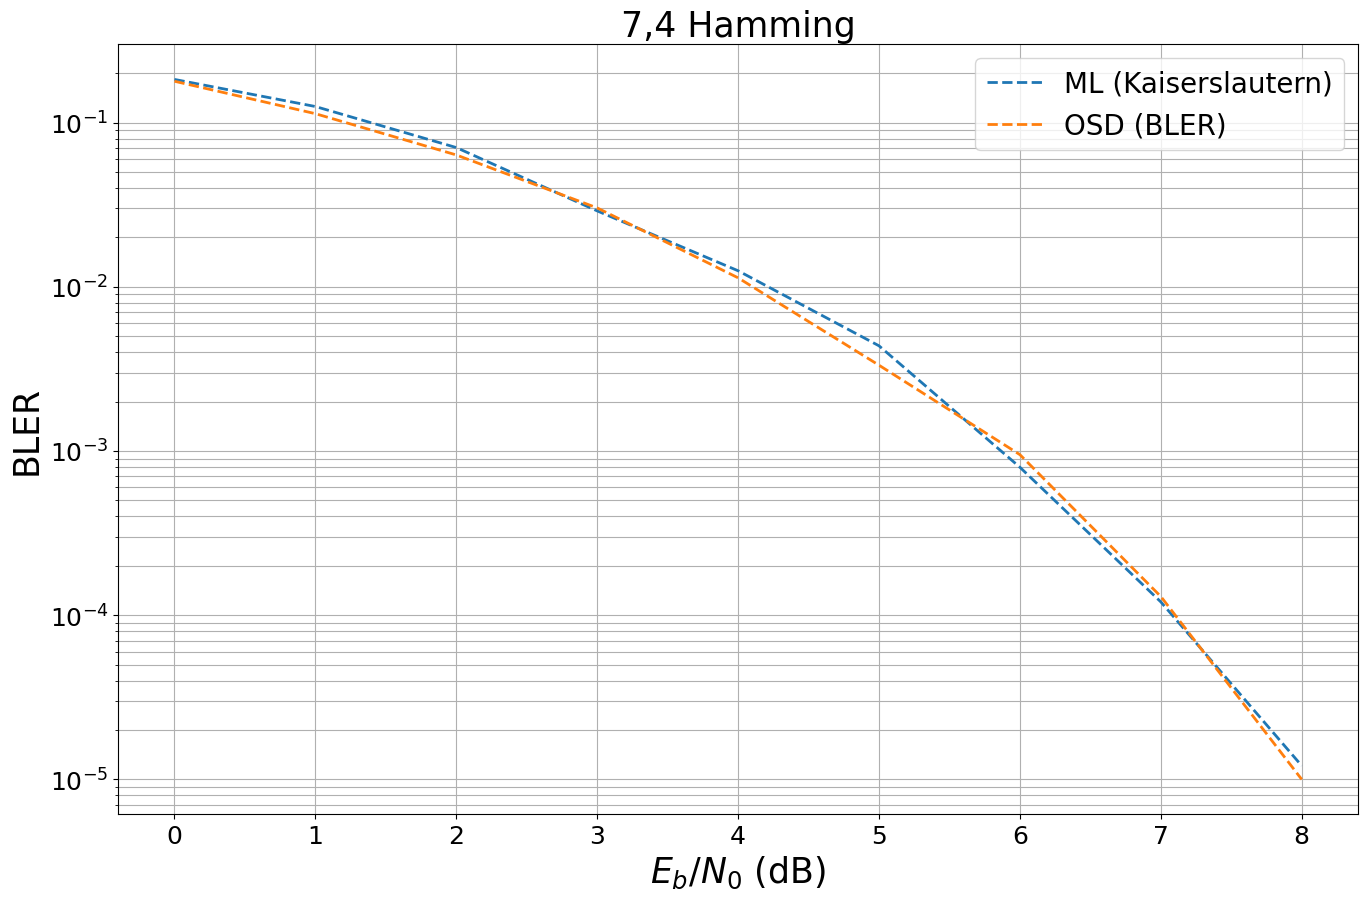

In [5]:
ebno_db = np.linspace(0, 8, 9) # sim SNR range 
id = 0 # 7,4 Hamming
pcm, k, n, coderate = load_parity_check_examples(id, verbose=False)

# init components
enc = LinearEncoder(pcm, is_pcm=True)
#dec = OSDecoder(pcm, is_pcm=True, t=2)
dec = OSDecoder(encoder=enc, t=2)
model = System_Model(enc, dec, cw_estimate=True)

# and run simulation
ber_plot = PlotBER(f"7,4 Hamming")

# add TU KL reference curves
# https://www.uni-kl.de/fileadmin/chaco/public/results_bch/BCH_N7_K4_ML.txt
snrs_ref = np.linspace(0, 8, 9)
blers_ref = np.array([1.832e-01, 1.253e-01, 7.047e-02, 2.899e-02, 1.252e-02, 4.371e-03, 7.962e-04, 1.205e-04, 1.211e-05])
ber_plot.add(snrs_ref, blers_ref, is_bler=True, legend="ML (Kaiserslautern)")

ber_plot.simulate(model, 
                  ebno_dbs=ebno_db, 
                  legend="OSD",
                  max_mc_iter=100, 
                  num_target_block_errors=2000, 
                  batch_size=1000, 
                  soft_estimates=False, 
                  early_stop=True,
                  show_fig=False, 
                  add_bler=True,
                  forward_keyboard_interrupt=True); 

ber_plot(show_ber=False)             

## Evaluate (63,45) BCH


n: 63, k: 45, coderate: 0.714
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.1772e-01 | 7.2100e-01 |       22250 |      189000 |         2163 |        3000 |         1.4 |reached target block errors
      0.5 | 9.2948e-02 | 5.8825e-01 |       23423 |      252000 |         2353 |        4000 |         0.0 |reached target block errors
      1.0 | 6.3152e-02 | 4.1600e-01 |       19893 |      315000 |         2080 |        5000 |         0.1 |reached target block errors
      1.5 | 3.9486e-02 | 2.6625e-01 |       19901 |      504000 |         2130 |        8000 |         0.1 |reached target block errors
      2.0 | 2.1156e-02 | 1.4643e-01 |       18660 |      882000 |         2050 |       14000 |         0.2 |reached target block errors
      2.5 | 9.4127e-03 | 6.7033e-0

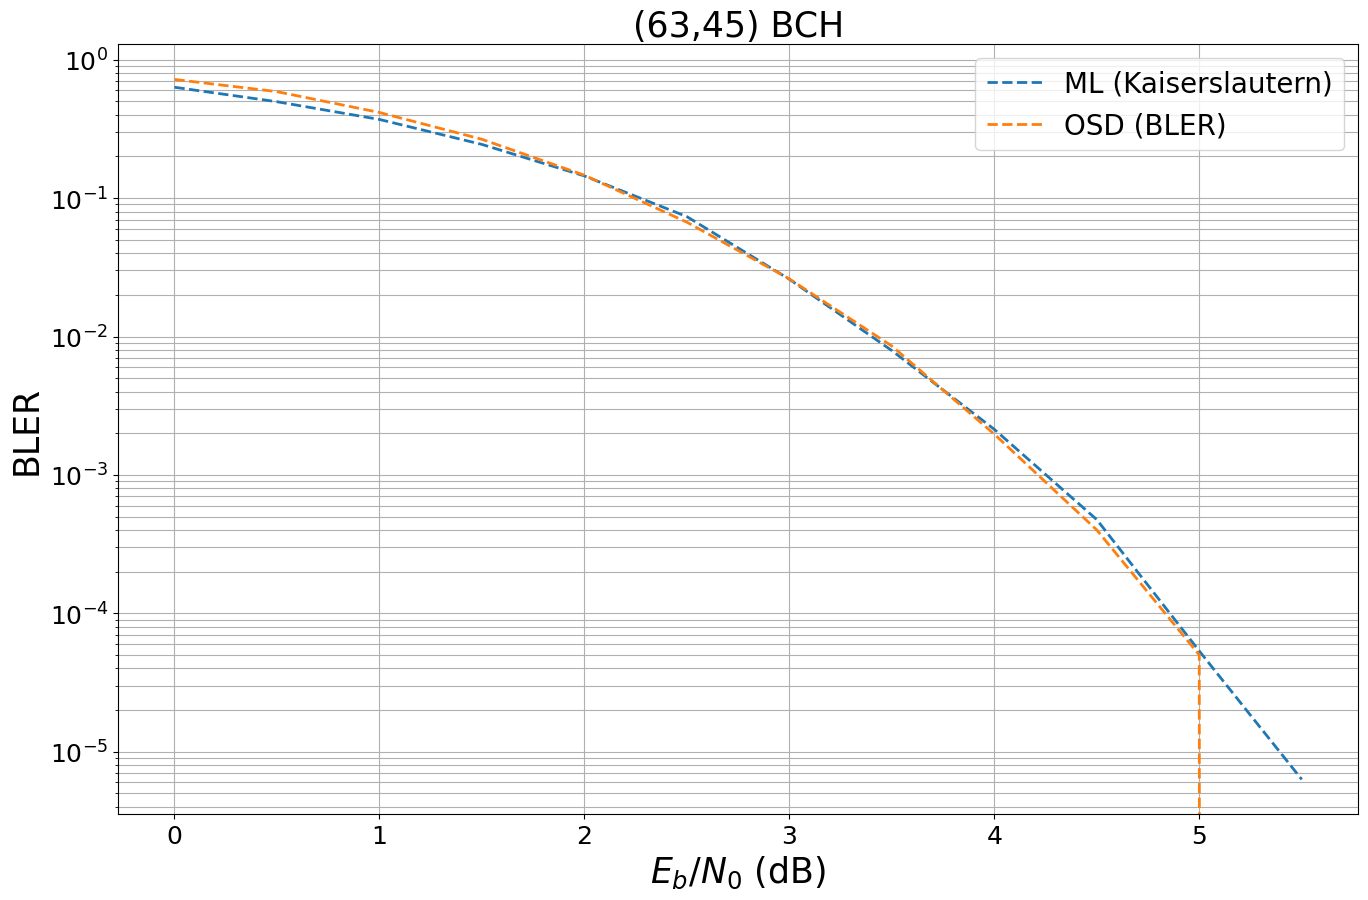

In [6]:
ebno_db = np.linspace(0, 5.5, 12) # sim SNR range 
id = 1 # 63,45 BCH
pcm, k, n, coderate = load_parity_check_examples(id, verbose=True)

# init components
enc = LinearEncoder(pcm, is_pcm=True)
dec = OSDecoder(encoder=enc, t=2, dtype=tf.float32)
model = System_Model(enc, dec, cw_estimate=True)

# and run simulation
ber_plot = PlotBER(f"(63,45) BCH")

# add TU KL reference curves
# https://www.uni-kl.de/fileadmin/chaco/public/results_bch/BCH_N63_K45_ML.txt
snrs_ref = np.linspace(0,5.5,12)
blers_ref = np.array([6.329e-01,4.975e-01,3.704e-01, 2.445e-01, 1.447e-01, 7.353e-02,2.595e-02, 7.918e-03, 2.134e-03,4.751e-04,5.337e-05,6.300e-06])
ber_plot.add(snrs_ref, blers_ref, is_bler=True, legend="ML (Kaiserslautern)")

ber_plot.simulate(model, 
                  ebno_dbs=ebno_db, 
                  legend="OSD",
                  max_mc_iter=100, 
                  num_target_block_errors=2000, 
                  batch_size=1000, 
                  soft_estimates=False, 
                  early_stop=True,
                  show_fig=False, 
                  add_bler=True,
                  forward_keyboard_interrupt=True); 
                  
ber_plot(show_ber=False)       

## Evaluate Polar & SCL

Note: Required memory complexity is large for the given code parameters and t=4. Please consider small batch-sizes to keep the inference complexity small and activate XLA mode if possible.
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.8106e-01 | 7.7500e-01 |       67454 |      240000 |         2325 |        3000 |        50.6 |reached target block errors
      1.0 | 1.2294e-01 | 4.0480e-01 |       49174 |      400000 |         2024 |        5000 |         1.1 |reached target block errors
      2.0 | 2.5726e-02 | 1.0984e-01 |       39104 |     1520000 |         2087 |       19000 |         4.1 |reached target block errors
      3.0 | 2.8274e-03 | 1.4890e-02 |       22619 |     8000000 |         1489 |      100000 |        21.6 |reached max iter       
      4.0 | 1.80

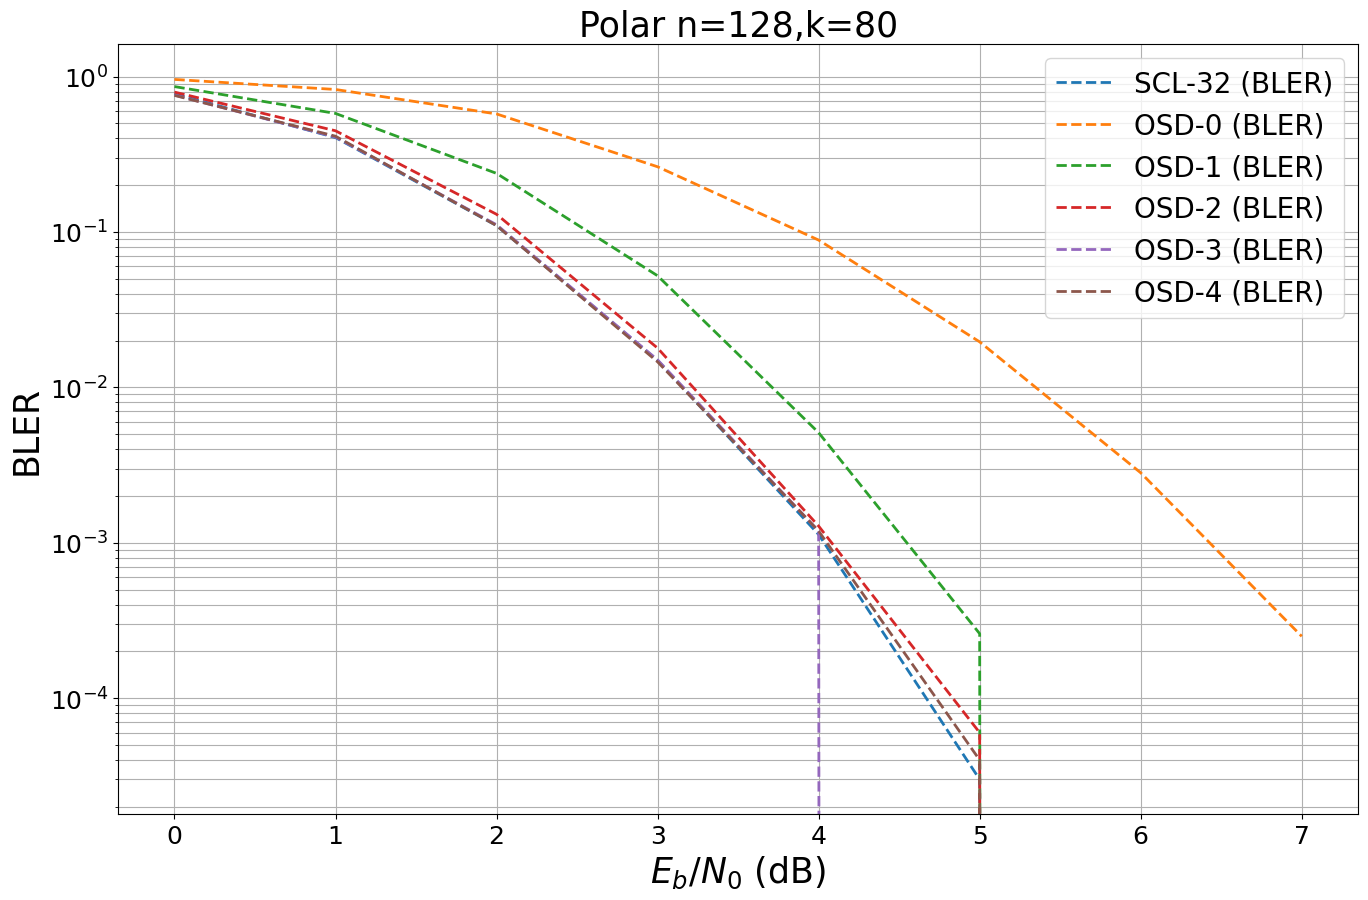

In [7]:
ebno_db = np.linspace(0, 7, 8) # sim SNR range 

k = 80
n = 128
f, _ = generate_5g_ranking(k, n)
# init components
enc = PolarEncoder(f, n)
dec = OSDecoder(encoder=enc, t=4)
model = System_Model(enc, dec, cw_estimate=True)

dec_ref = PolarSCLDecoder(f, n, list_size=32)
model_ref = System_Model(enc, dec_ref, cw_estimate=False)


# and run simulation
ber_plot = PlotBER(f"Polar n={n},k={k}")

# reference with Polar SCL
ber_plot.simulate(model_ref, 
                  ebno_dbs=ebno_db, 
                  legend=f"SCL-{dec_ref.list_size}",
                  max_mc_iter=100, 
                  num_target_block_errors=2000, 
                  batch_size=1000, 
                  soft_estimates=False, 
                  early_stop=True,
                  show_fig=False, 
                  add_bler=True,
                  forward_keyboard_interrupt=True); 

# sweep over t
for t in range(5):
    dec = OSDecoder(encoder=enc, t=t)
    model = System_Model(enc, dec, cw_estimate=True)
    ber_plot.simulate(model, 
                    ebno_dbs=ebno_db, 
                    legend=f"OSD-{dec.t}",
                    max_mc_iter=100, 
                    num_target_block_errors=2000, 
                    batch_size=1000, 
                    soft_estimates=False, 
                    early_stop=True,
                    show_fig=False, 
                    add_bler=True,
                    forward_keyboard_interrupt=True); 


# ber is not comparable (u_hat vs. c_hat)
ber_plot(show_ber=False)


**Remark**: SCL-32 is not necessarily optimal for longer codes.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.3296e-01 | 3.1857e-01 |       14891 |      112000 |         2230 |        7000 |         8.6 |reached target block errors
      1.0 | 6.4558e-02 | 1.5746e-01 |       13428 |      208000 |         2047 |       13000 |         0.3 |reached target block errors
      2.0 | 2.2788e-02 | 5.6389e-02 |       13126 |      576000 |         2030 |       36000 |         0.7 |reached target block errors
      3.0 | 5.3969e-03 | 1.3350e-02 |        8635 |     1600000 |         1335 |      100000 |         2.0 |reached max iter       
      4.0 | 7.5875e-04 | 1.9200e-03 |        1214 |     1600000 |          192 |      100000 |         2.0 |reached max iter       
      5.0 | 3.6875e-05 | 1.2000e-04 |          59 |     1600000 |        

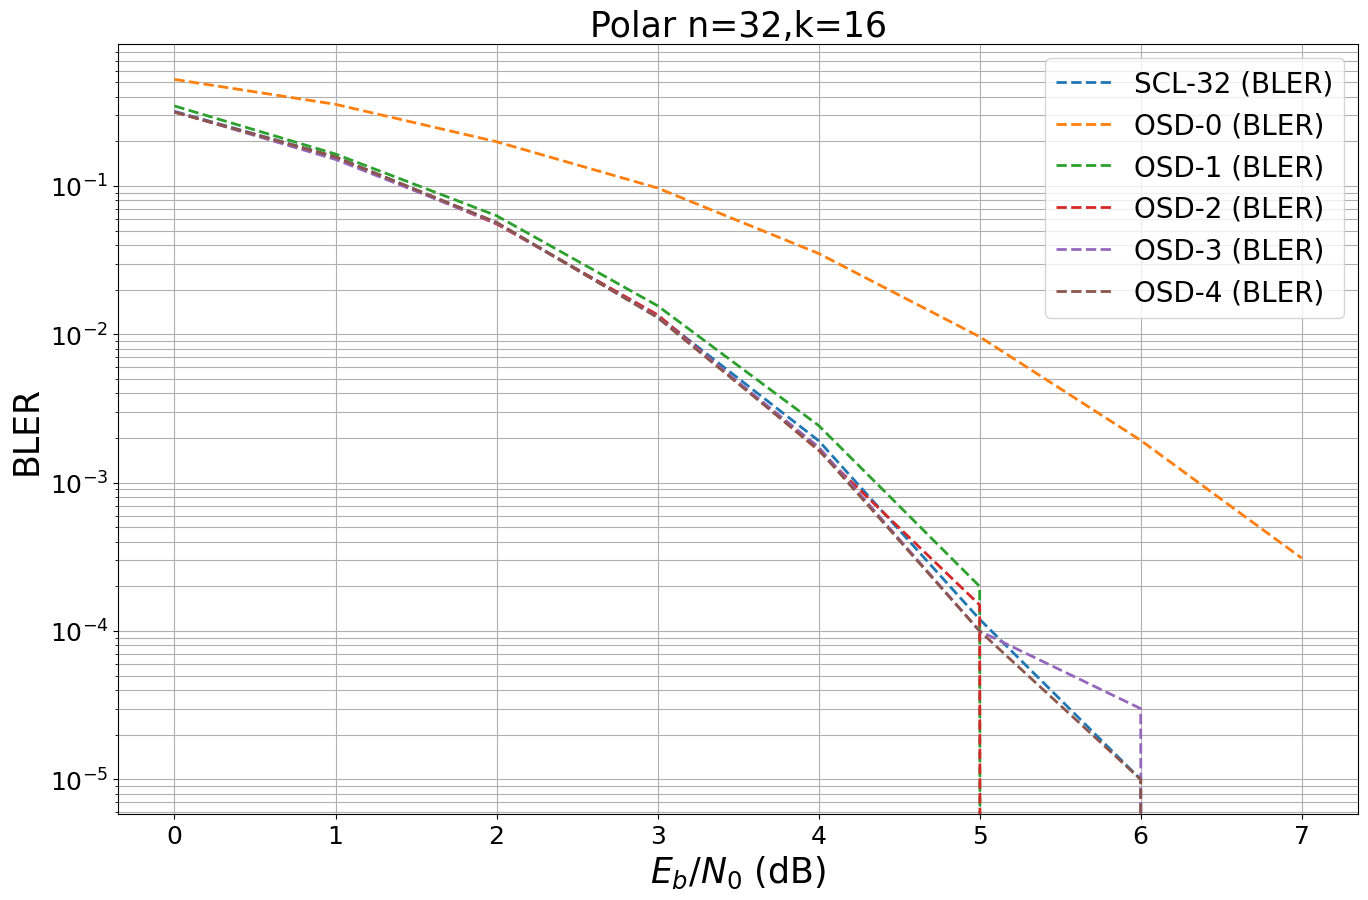

In [10]:
# very short polar codes

ebno_db = np.linspace(0, 7, 8) # sim SNR range 

k = 16
n = 32
f, _ = generate_5g_ranking(k, n)
# init components
enc = PolarEncoder(f, n)
dec = OSDecoder(encoder=enc, t=4)
model = System_Model(enc, dec, cw_estimate=True)

dec_ref = PolarSCLDecoder(f, n, list_size=32)
model_ref = System_Model(enc, dec_ref, cw_estimate=False)


# and run simulation
ber_plot = PlotBER(f"Polar n={n},k={k}")

# reference with Polar SCL
ber_plot.simulate(model_ref, 
                  ebno_dbs=ebno_db, 
                  legend=f"SCL-{dec_ref.list_size}",
                  max_mc_iter=100, 
                  num_target_block_errors=2000, 
                  batch_size=1000, 
                  soft_estimates=False, 
                  early_stop=True,
                  show_fig=False, 
                  add_bler=True,
                  forward_keyboard_interrupt=True); 

# sweep over t
for t in range(5):
    dec = OSDecoder(encoder=enc, t=t)
    model = System_Model(enc, dec, cw_estimate=True)
    ber_plot.simulate(model, 
                    ebno_dbs=ebno_db, 
                    legend=f"OSD-{dec.t}",
                    max_mc_iter=100, 
                    num_target_block_errors=2000, 
                    batch_size=1000, 
                    soft_estimates=False, 
                    early_stop=True,
                    show_fig=False, 
                    add_bler=True,
                    forward_keyboard_interrupt=True); 


# ber is not comparable (u_hat vs. c_hat)
ber_plot(show_ber=False)


## Evaluate Convolutional Codes & Viterbi

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.1179e-01 | 9.2033e-01 |       40244 |      360000 |         2761 |        3000 |         1.2 |reached target block errors
      1.0 | 4.5253e-02 | 6.7300e-01 |       16291 |      360000 |         2019 |        3000 |         0.0 |reached target block errors
      2.0 | 1.2489e-02 | 3.2414e-01 |       10491 |      840000 |         2269 |        7000 |         0.1 |reached target block errors
      3.0 | 2.7575e-03 | 1.0905e-01 |        6287 |     2280000 |         2072 |       19000 |         0.3 |reached target block errors
      4.0 | 6.1399e-04 | 3.6411e-02 |        4126 |     6720000 |         2039 |       56000 |         0.8 |reached target block errors
      5.0 | 1.5267e-04 | 1.1830e-02 |        1832 |    12000000 |

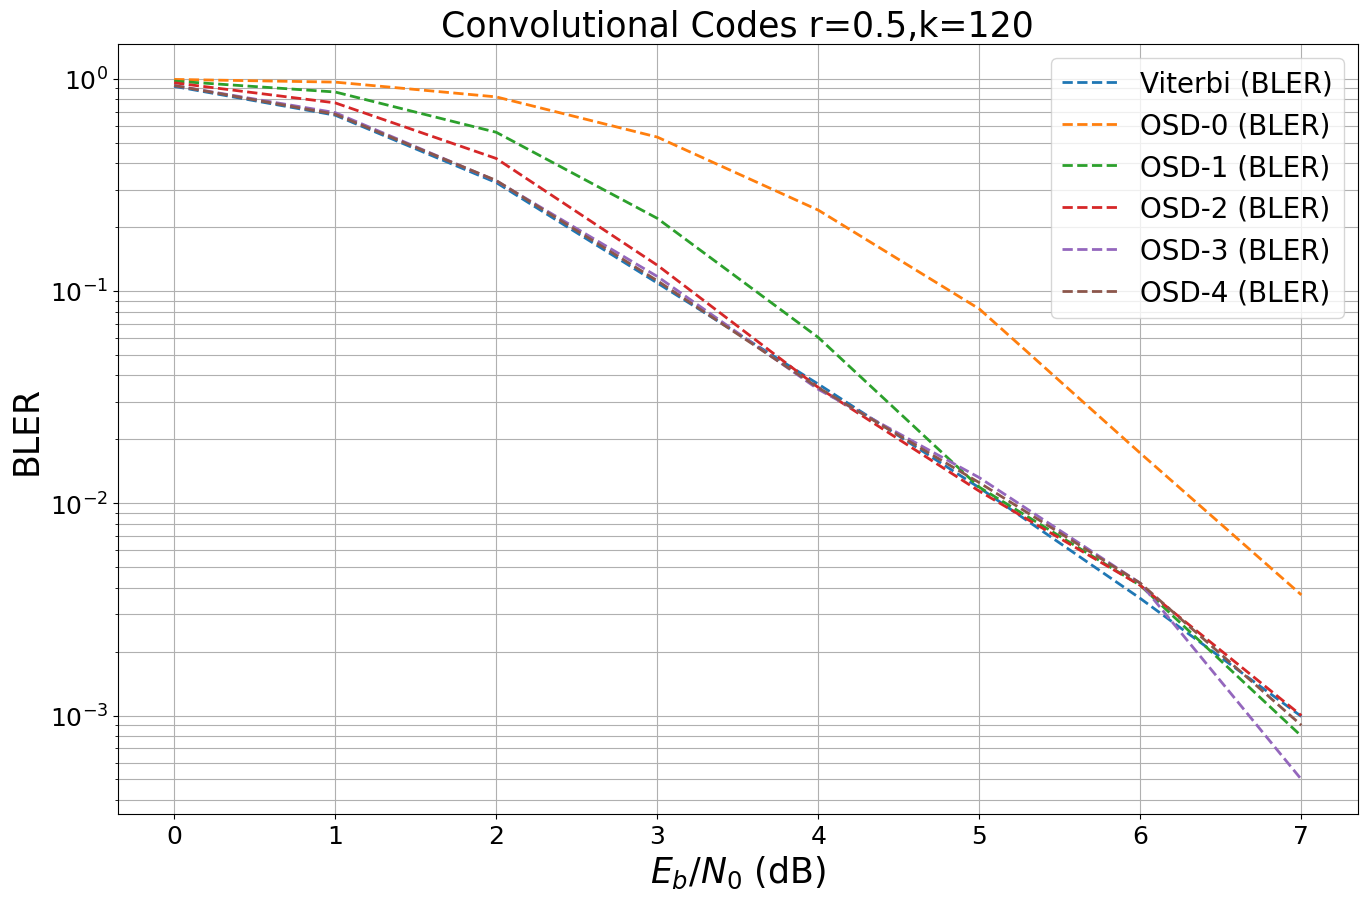

In [12]:
# very short polar codes

ebno_db = np.linspace(0, 7, 8) # sim SNR range 

k = 120
constraint_length = 5
r = 0.5

# init components
enc = ConvEncoder(rate=r, constraint_length=constraint_length)
# init encoder
enc(tf.zeros((1, k)))

dec_ref = ViterbiDecoder(rate=r, constraint_length=constraint_length)
model_ref = System_Model(enc, dec_ref, cw_estimate=False)


# and run simulation
ber_plot = PlotBER(f"Convolutional Codes r={r}, k={k}")

# reference with Polar SCL
ber_plot.simulate(model_ref, 
                  ebno_dbs=ebno_db, 
                  legend=f"Viterbi",
                  max_mc_iter=100, 
                  num_target_block_errors=2000, 
                  batch_size=1000, 
                  soft_estimates=False, 
                  early_stop=True,
                  show_fig=False, 
                  add_bler=True,
                  forward_keyboard_interrupt=True); 

# sweep over t
for t in range(5):
    dec = OSDecoder(encoder=enc, t=t)
    model = System_Model(enc, dec, cw_estimate=True)
    ber_plot.simulate(model, 
                    ebno_dbs=ebno_db, 
                    legend=f"OSD-{dec.t}",
                    max_mc_iter=100, 
                    num_target_block_errors=2000, 
                    batch_size=100, 
                    soft_estimates=False, 
                    early_stop=True,
                    show_fig=False, 
                    add_bler=True,
                    forward_keyboard_interrupt=True); 


# ber is not comparable (u_hat vs. c_hat)
ber_plot(show_ber=False)
